In [1]:
%load_ext autoreload
%autoreload 2
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchtext import data, datasets
import spacy
from matplotlib import pyplot as plt
import numpy as np
from tqdm.auto import tqdm

dev = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from utils import WMT14En2DeDatasetTokenizer, get_trainer_model
dataset = WMT14En2DeDatasetTokenizer(dev=dev)

Generating src vocab...
Generating trg vocab...
Done.


In [8]:
dl = DataLoader(
    dataset.train,
    shuffle=True,
    batch_size=1,
    collate_fn=dataset.collate_fn)
example =  next(iter(dl))
{a: example[a].shape for a in example}
a = []
for i, batch in enumerate(dl):
    if i > 10000:
        break
    a.append(batch['ntokens'].cpu())
a = np.array(a)

In [9]:
25000 / 350 / a.mean()

2.7977470317473374

In [10]:
a.mean() * 350 * 3

26807.28427157284

In [ ]:
len(dl)

In [3]:
from transformers.model import EncoderDecoder, Trainer

trainer, model = get_trainer_model(dataset, EncoderDecoder, Trainer, dev=dev)

error:  No checkpoints in ./chkpnts


In [4]:
f'{sum(p.numel() for p in model.parameters()) / 1e6} * 1e6 parameters'

'69.978857 * 1e6 parameters'

  0%|          | 0/1000000 [00:00<?, ?it/s]

KeyboardInterrupt: 

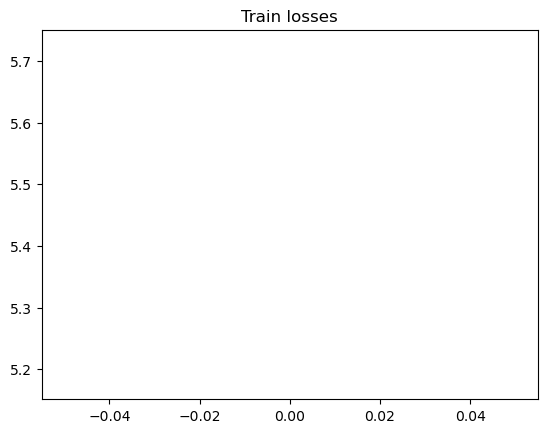

In [5]:
trainer.train_loop(1_000_000, batch_size=350, save=True, notify=True)

In [ ]:
test_dl = DataLoader(
    dataset.train, shuffle=True, batch_size=1, collate_fn=dataset.collate_fn)
example =  next(iter(test_dl))

src = example['src']
src_mask = example['src_mask']

model.eval()
trg = model.translate(
    src, src_mask, dataset, dev=dev)
dataset.itos(src[0], field='src'), dataset.itos(trg[0])

In [ ]:
plt.plot(trainer.losses)